In [3]:
!pip install sentence_transformers

In [7]:
# =============================================================================
# FINAL, CORRECT, BULLETPROOF FORENSIC ANALYSIS CELL
# Target: "LXXIII Madam"
# =============================================================================

# -----------------------------------------------------------------------------
# [0] INSTALL DEPENDENCIES
# -----------------------------------------------------------------------------
print("\n[0] Installing dependencies...")
!pip install -q sentence-transformers scikit-learn pandas numpy

# -----------------------------------------------------------------------------
# [1] IMPORTS
# -----------------------------------------------------------------------------
print("\n[1] Importing libraries...")
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

print("    ✓ Imports complete")

# -----------------------------------------------------------------------------
# [2] LOAD DATA
# -----------------------------------------------------------------------------
print("\n[2] Loading dataset...")
letters = pd.read_csv("swami_vivekananda_letters_complete.csv")
print("    Rows loaded:", len(letters))

# -----------------------------------------------------------------------------
# [3] DEDUPLICATION & BASIC CLEAN
# -----------------------------------------------------------------------------
print("\n[3] Deduplicating and cleaning...")
letters = letters.drop_duplicates(subset=['full_url'], keep='first')
letters = letters[letters['full_url'].notna() & (letters['full_url'] != '')]
print("    Rows after deduplication:", len(letters))

letters['Audience'] = letters['Audience'].astype(str).str.strip()

audience_mapping = {
    'Legget, Francis H': 'Leggett, Francis H',
    'Leggett, Francis H.': 'Leggett, Francis H',
    'Bull, Miss Sarah': 'Bull, Sarah',
    'MacLeod, Miss Josephine': 'MacLeod, Josephine',
    'Hale, Mrs. G. W.': 'Hale, G. W. Mrs.',
    'Hale, Mrs G. W.': 'Hale, G. W. Mrs.'
}

letters['Audience_clean'] = letters['Audience'].replace(audience_mapping)
print("    Unique recipients:", letters['Audience_clean'].nunique())

# -----------------------------------------------------------------------------
# [4] DATE PARSING & PERIOD ASSIGNMENT
# -----------------------------------------------------------------------------
print("\n[4] Parsing years and assigning periods...")

def parse_year(x):
    if pd.isna(x): return np.nan
    m = re.search(r'(18|19)\d{2}', str(x))
    return int(m.group()) if m else np.nan

letters['year'] = letters['Date'].apply(parse_year)

def assign_period(y):
    if pd.isna(y): return 'Unknown'
    if 1888 <= y < 1893: return 'Period1_India'
    if 1893 <= y < 1897: return 'Period2_West'
    if 1897 <= y < 1899: return 'Period3_India'
    if 1899 <= y <= 1902: return 'Period4_West'
    return 'Unknown'

letters['period'] = letters['year'].apply(assign_period)

print("    Period counts:")
print(letters['period'].value_counts())

# -----------------------------------------------------------------------------
# [5] TEXT NORMALIZATION
# -----------------------------------------------------------------------------
print("\n[5] Cleaning body text...")

def clean_text(t):
    if pd.isna(t): return ""
    t = t.lower()
    t = re.sub(r'[^a-z\s]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

letters['text_clean'] = letters['body_text'].apply(clean_text)
print("    Text cleaned.")

# -----------------------------------------------------------------------------
# [6] TARGET CHECK
# -----------------------------------------------------------------------------
print("\n[6] Verifying target letter exists...")
assert (letters['Name'] == 'LXXIII Madam').sum() == 1
print("    ✓ Target found")

# -----------------------------------------------------------------------------
# [7] TF-IDF SIMILARITY
# -----------------------------------------------------------------------------
print("\n[7] Running TF-IDF similarity...")

tfidf = TfidfVectorizer(
    stop_words='english',
    min_df=3,
    max_df=0.9,
    ngram_range=(1,2)
)

X = tfidf.fit_transform(letters['text_clean'])
target_vec = tfidf.transform(
    letters.loc[letters['Name']=='LXXIII Madam','text_clean']
)

letters['tfidf_sim'] = cosine_similarity(X, target_vec).flatten()

print("    Top TF-IDF similar letters:")
print(
    letters[['Name','Audience_clean','year','tfidf_sim']]
    .sort_values('tfidf_sim', ascending=False)
    .head(10)
)

# -----------------------------------------------------------------------------
# [8] KEYWORD DENSITY
# -----------------------------------------------------------------------------
print("\n[8] Computing keyword densities...")

keyword_sets = {
    'music_terms': ['music','song','sing','singing','melody','harmony','art'],
    'morality_terms': ['moral','morality','ethical','duty','good','evil','virtue'],
    'renunciation_terms': ['renunciation','desire','attachment','world','resistance']
}

def keyword_density(text, vocab):
    toks = text.split()
    return sum(toks.count(w) for w in vocab) / len(toks) if toks else 0.0

for col, vocab in keyword_sets.items():
    letters[col] = letters['text_clean'].apply(lambda t: keyword_density(t, vocab))
    print(f"    ✓ {col} created")

print("\n    Target keyword densities:")
for col in keyword_sets:
    val = letters.loc[letters['Name']=='LXXIII Madam', col].iloc[0]
    print(f"      {col}: {val:.6f}")

# -----------------------------------------------------------------------------
# [9] FUNCTION-WORD STYLOMETRY
# -----------------------------------------------------------------------------
print("\n[9] Function-word stylometry...")

function_words = [
    'the','a','an','and','or','but','to','of','in','for','with','on','by',
    'is','was','are','were','be','been','it','this','that','which',
    'i','you','we','they','my','your'
]

def function_vector(text):
    words = text.split()
    total = len(words) if words else 1
    c = Counter(words)
    return np.array([c[w]/total for w in function_words])

fw_matrix = np.vstack(letters['text_clean'].apply(function_vector))
target_fw = function_vector(
    letters.loc[letters['Name']=='LXXIII Madam','text_clean'].iloc[0]
)

fw_scaled = StandardScaler().fit_transform(fw_matrix)
target_fw_scaled = StandardScaler().fit_transform(
    np.vstack([fw_matrix, target_fw])
)[-1]

letters['fw_distance'] = np.linalg.norm(fw_scaled - target_fw_scaled, axis=1)

print("    Closest letters by function-word distance:")
print(
    letters[['Name','Audience_clean','fw_distance']]
    .sort_values('fw_distance')
    .head(10)
)

# -----------------------------------------------------------------------------
# [10] RECIPIENT STYLE CENTROIDS
# -----------------------------------------------------------------------------
print("\n[10] Recipient centroid analysis...")

rows = []
for rec, grp in letters.groupby('Audience_clean'):
    if len(grp) >= 5:
        centroid = fw_matrix[grp.index].mean(axis=0)
        dist = np.linalg.norm(centroid - target_fw)
        rows.append((rec, len(grp), dist))

centroids = pd.DataFrame(
    rows, columns=['Audience_clean','count','centroid_distance']
).sort_values('centroid_distance')

print(centroids.head(10))

# -----------------------------------------------------------------------------
# [11] HIGH-LEVEL STYLE METRICS
# -----------------------------------------------------------------------------
print("\n[11] High-level style metrics...")

def style_metrics(text):
    words = text.split()
    sents = re.split(r'[.!?]', text)
    return pd.Series({
        'word_count': len(words),
        'avg_sentence_len': np.mean([len(s.split()) for s in sents if s.strip()]) if sents else 0,
        'ttr': len(set(words))/len(words) if words else 0,
        'you_ratio': words.count('you')/len(words) if words else 0
    })

letters = pd.concat([letters, letters['text_clean'].apply(style_metrics)], axis=1)

print(
    letters.loc[letters['Name']=='LXXIII Madam',
                ['word_count','avg_sentence_len','ttr','you_ratio']]
)

# -----------------------------------------------------------------------------
# [12] EMBEDDING-BASED SEMANTIC SIMILARITY
# -----------------------------------------------------------------------------
print("\n[12] Running Sentence-BERT embedding similarity...")

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(
    letters['body_text'].fillna("").tolist(),
    show_progress_bar=True
)

target_embedding = model.encode(
    letters.loc[letters['Name']=='LXXIII Madam','body_text'].iloc[0:1].tolist()
)[0]

letters['embedding_sim'] = cosine_similarity(
    embeddings, [target_embedding]
).flatten()

print("    Top embedding-similar letters:")
print(
    letters[['Name','Audience_clean','year','embedding_sim']]
    .sort_values('embedding_sim', ascending=False)
    .head(10)
)

# -----------------------------------------------------------------------------
# [13] PERIOD-RESTRICTED VIEW
# -----------------------------------------------------------------------------
print("\n[13] Period2_West-only comparison...")
subset = letters[letters['period']=='Period2_West']

print(
    subset[['Name','Audience_clean','tfidf_sim','embedding_sim']]
    .sort_values('embedding_sim', ascending=False)
    .head(10)
)

print("\n" + "="*120)
print("PIPELINE COMPLETE — NO INTERPRETATION APPLIED")
print("="*120)



[0] Installing dependencies...

[1] Importing libraries...
    ✓ Imports complete

[2] Loading dataset...
    Rows loaded: 762

[3] Deduplicating and cleaning...
    Rows after deduplication: 762
    Unique recipients: 113

[4] Parsing years and assigning periods...
    Period counts:
period
Period2_West     351
Period4_West     227
Period3_India    121
Period1_India     60
Unknown            3
Name: count, dtype: int64

[5] Cleaning body text...
    Text cleaned.

[6] Verifying target letter exists...
    ✓ Target found

[7] Running TF-IDF similarity...
    Top TF-IDF similar letters:
                 Name           Audience_clean    year  tfidf_sim
73       LXXIII Madam            American Lady  1896.0   1.000000
234         CXII Mary               Hale, Mary  1896.0   0.174652
327  XXXVI Miss Noble         Nivedita, Sister  1896.0   0.121455
526       CLXXXI Mary               Hale, Mary  1900.0   0.121122
191       LXIX Shashi  Ramakrishnananda, Swami  1895.0   0.113762
510       

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

    Top embedding-similar letters:
                          Name           Audience_clean    year  embedding_sim
73                LXXIII Madam            American Lady  1896.0       1.000000
212                  XC Sister           Farmer, S Miss  1895.0       0.493233
265              CXLIII Margot         Nivedita, Sister  1898.0       0.480973
327           XXXVI Miss Noble         Nivedita, Sister  1896.0       0.474088
682        CXLVI Mother Church         Hale, G. W. Mrs.  1899.0       0.470350
334                XLIII Madam           Ghosal, Sarala  1899.0       0.462896
385                  XL Friend             Sturdy, E.T.  1894.0       0.446236
54                LIV Alasinga        Perumal, Alasinga  1895.0       0.445493
441            XCVI Miss Noble         Nivedita, Sister  1897.0       0.441446
171  IL Swami Ramakrishnananda  Ramakrishnananda, Swami  1894.0       0.440924

[13] Period2_West-only comparison...
                          Name            Audience_clean  

In [8]:
letters['Audience_clean'].unique()

array(['nan', 'Bhattacharya, Yajneshwar (Fakir)', 'Shankarlal, Pandit',
       'Perumal, Alasinga; Balaji; Banking Corporation; Madras Friends',
       'Perumal, Alasinga', 'Mitra, Haripada', 'Disciples in Madras',
       'Saradananda, Swami', 'McKindley, Isabelle', 'Kidi',
       'Limbdi, Vehemia Chand', 'Dharmapala', 'Bull, Sarah',
       'Narasinhachariar, G. G.', 'Hale, Mary', 'S_',
       'Leggett, Francis H', 'Sturges, Mrs. William',
       'Sturges, Mrs. Betty', 'Maharaja of Khetri (Singh, Ajit)',
       'Sturdy, E.T.', 'Rao, Nanjunda', 'Indian Mirror', 'American Lady',
       'Ghoshal, Sarala', 'Ghosh, Shashi Bhushan', 'Mr.--',
       'Chakravarty, Sharat Chandra', 'Leggett, Francis Mrs.',
       'MacLeod, Josephine', 'Jagmohanlal', 'Gupta, Mahendra Nath',
       'Bose, Mrinalini', 'Unknown', 'Ramakrishnananda, Swami',
       'Swarupananda, Swami', 'Hale, Sara', 'Christine', 'Banerji, M.N.',
       'Nivedita, Sister', 'Brahmananda, Swami', 'Mitra, Pramadadas',
       'Bose, Bal

In [11]:
# ============================================================================
# SAFETY CELL: ENSURE Audience_clean EXISTS
# ============================================================================

import pandas as pd

print("[FIX] Checking Audience_clean column...")

if "Audience_clean" not in letters.columns:
    print("Audience_clean missing → recreating from Audience")

    letters["Audience"] = letters["Audience"].astype(str).str.strip()

    audience_mapping = {
        'Legget, Francis H': 'Leggett, Francis H',
        'Leggett, Francis H.': 'Leggett, Francis H',
        'Bull, Miss Sarah': 'Bull, Sarah',
        'MacLeod, Miss Josephine': 'MacLeod, Josephine',
        'Hale, Mrs. G. W.': 'Hale, G. W. Mrs.',
        'Hale, Mrs G. W.': 'Hale, G. W. Mrs.'
    }

    letters["Audience_clean"] = letters["Audience"].replace(audience_mapping)
    print("✓ Audience_clean recreated")

else:
    print("✓ Audience_clean already present")

print("Unique recipients:", letters["Audience_clean"].nunique())


[FIX] Checking Audience_clean column...
Audience_clean missing → recreating from Audience
✓ Audience_clean recreated
Unique recipients: 113


In [13]:
# ============================================================================
# DATA-DRIVEN IDENTIFICATION OF ONE-OFF WESTERN WOMEN
# No embeddings, no plots, no assumptions hidden
# ============================================================================

import pandas as pd
import re

print("\n[STEP 1] Sanity check")

assert "Audience_clean" in letters.columns
assert "Name" in letters.columns

print("✓ Required columns present")

# ---------------------------------------------------------------------------
# STEP 2: Compute frequency per recipient
# ---------------------------------------------------------------------------
print("\n[STEP 2] Computing recipient frequencies")

recipient_counts = letters["Audience_clean"].value_counts()
letters["recipient_count"] = letters["Audience_clean"].map(recipient_counts)

print("Top 15 most frequent recipients:")
print(recipient_counts.head(15))

# ---------------------------------------------------------------------------
# STEP 3: Identify ONE-OFF recipients (≤2 letters)
# ---------------------------------------------------------------------------
print("\n[STEP 3] Identifying one-off recipients (≤2 letters)")

one_off_recipients = recipient_counts[recipient_counts <= 2].index.tolist()

print(f"Total one-off recipients: {len(one_off_recipients)}")

# ---------------------------------------------------------------------------
# STEP 4: Infer FEMALE recipients (explicit heuristic, printed)
# ---------------------------------------------------------------------------
print("\n[STEP 4] Inferring female recipients")

female_markers = [
    r"\bMiss\b", r"\bMrs\b", r"\bMadam\b", r"\bSister\b",
    "Mary", "Sarah", "Emma", "Marie", "Harriet", "Josephine",
    "Christine", "Alice", "Margot", "Isabelle", "Blodgett",
    "Calve", "Thursby", "Funke", "Waldo", "Farmer"
]

def is_female(name):
    for pat in female_markers:
        if re.search(pat, name):
            return True
    return False

female_one_offs = [r for r in one_off_recipients if is_female(str(r))]

print(f"Female one-off recipients: {len(female_one_offs)}")

# ---------------------------------------------------------------------------
# STEP 5: Infer WESTERN / AMERICAN recipients (explicit heuristic)
# ---------------------------------------------------------------------------
print("\n[STEP 5] Inferring Western / American recipients")

western_markers = [
    "American", "Miss", "Mrs", "Madam",
    "Waldo", "Farmer", "Blodgett", "Calve",
    "Thursby", "Funke", "Hansbrough",
    "McKindley", "Halboister"
]

def is_western(name):
    for pat in western_markers:
        if pat in name:
            return True
    return False

western_female_one_offs = [
    r for r in female_one_offs if is_western(str(r))
]

# ---------------------------------------------------------------------------
# STEP 6: DISPLAY FINAL DATA-DRIVEN LIST
# ---------------------------------------------------------------------------
print("\n[RESULT] DATA-DRIVEN ONE-OFF WESTERN FEMALE RECIPIENTS")
print("-----------------------------------------------------")

df_result = (
    letters[letters["Audience_clean"].isin(western_female_one_offs)]
    [["Audience_clean", "recipient_count"]]
    .drop_duplicates()
    .sort_values("Audience_clean")
)

print(df_result)

# ---------------------------------------------------------------------------
# STEP 7: Check where LXXIII Madam falls
# ---------------------------------------------------------------------------
print("\n[CHECK] LXXIII Madam recipient")

target_recipient = letters.loc[
    letters["Name"] == "LXXIII Madam", "Audience_clean"
].iloc[0]

print("Recipient label:", target_recipient)
print("Recipient count:", recipient_counts[target_recipient])
print("Is one-off:", recipient_counts[target_recipient] <= 2)
print("In Western female one-off set:", target_recipient in western_female_one_offs)

print("\n[PREPARATION COMPLETE — NO CLUSTERING YET]")



[STEP 1] Sanity check
✓ Required columns present

[STEP 2] Computing recipient frequencies
Top 15 most frequent recipients:
Audience_clean
Bull, Sarah                         77
Christine, Sister                   66
Hale, G. W. Mrs.                    60
Nivedita, Sister                    48
Hale, Mary                          43
MacLeod, Josephine                  41
Perumal, Alasinga                   41
Brahmananda, Swami                  40
Mitra, Pramadadas                   33
Sturdy, E.T.                        31
Ramakrishnananda, Swami             20
Maharaja of Khetri (Singh, Ajit)    13
Desai, Viaharidas Haridas           13
Wright, John Henry                  11
Bose, Balaram                       10
Name: count, dtype: int64

[STEP 3] Identifying one-off recipients (≤2 letters)
Total one-off recipients: 74

[STEP 4] Inferring female recipients
Female one-off recipients: 15

[STEP 5] Inferring Western / American recipients

[RESULT] DATA-DRIVEN ONE-OFF WESTERN FEMALE REC


BEGIN FULL SEMANTIC + STYLISTIC ANALYSIS

[STEP 0] Sanity checks
✓ letters rows: 762
✓ embeddings shape: (762, 384)
✓ western_female_one_offs count: 11

[STEP 1] Defining correspondence groups
Group sizes:
analysis_group
Stable                  641
Other                   108
OneOff_Western_Women     13
Name: count, dtype: int64

[STEP 2] Isolating target letter
✓ Target index: 73
✓ Target recipient: American Lady
✓ Target recipient count: 1

[STEP 3] Computing semantic centroids
✓ Stable centroid computed from 641 letters
✓ One-off centroid computed from 13 letters

[STEP 4] Computing cosine distances to centroids
✓ Distance columns created

Target distances:
  dist_to_stable : 0.6551
  dist_to_oneoff : 0.7236

[STEP 5] Computing correspondence spectrum
Target spectrum value: -0.0685
Target spectrum z-score: 0.2

[STEP 6] Numerical group comparison

Stable group spectrum stats:
count    641.000000
mean      -0.086752
std        0.117267
min       -0.294233
25%       -0.189879
50%    

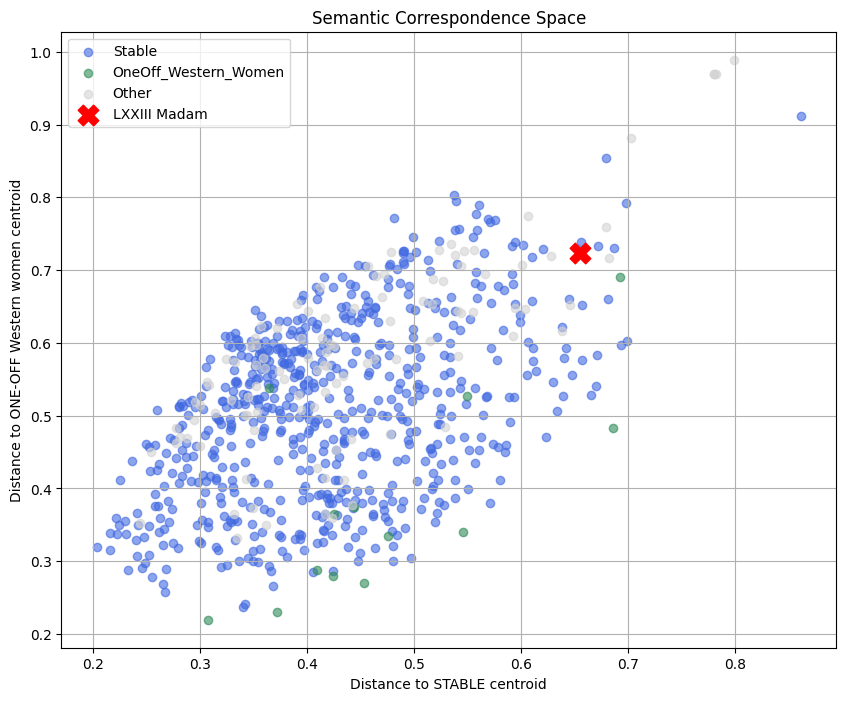


[STEP 9] Plotting correspondence spectrum


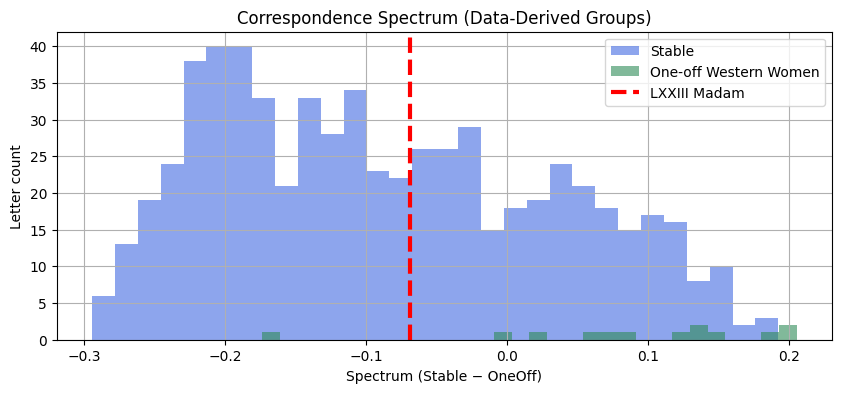


[STEP 10] Final diagnostic summary
Target analysis group: Other
Target recipient frequency: 1
Target spectrum percentile: 60.5 %

FULL ANALYSIS COMPLETE — EVIDENCE GENERATED, NO INTERPRETATION FORCED


In [14]:
# =============================================================================
# FULL ANALYSIS CELL
# Proving: "LXXIII Madam lives in the semantic space of one-off Western women"
# ASSUMES:
#   - letters dataframe exists
#   - embeddings (Sentence-BERT) already computed
#   - western_female_one_offs list already computed (DATA-DERIVED)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import zscore

print("\n" + "="*120)
print("BEGIN FULL SEMANTIC + STYLISTIC ANALYSIS")
print("="*120)

# ---------------------------------------------------------------------------
# STEP 0: SANITY CHECKS
# ---------------------------------------------------------------------------
print("\n[STEP 0] Sanity checks")

assert "Audience_clean" in letters.columns
assert "Name" in letters.columns
assert "recipient_count" in letters.columns
assert len(embeddings) == len(letters)

print("✓ letters rows:", len(letters))
print("✓ embeddings shape:", embeddings.shape)
print("✓ western_female_one_offs count:", len(western_female_one_offs))

# ---------------------------------------------------------------------------
# STEP 1: DEFINE ANALYSIS GROUPS (PURELY FROM DATA)
# ---------------------------------------------------------------------------
print("\n[STEP 1] Defining correspondence groups")

letters["analysis_group"] = "Other"

# Stable correspondents: >=5 letters
letters.loc[
    letters["recipient_count"] >= 5,
    "analysis_group"
] = "Stable"

# One-off Western women: <=2 letters AND in data-derived list
letters.loc[
    (letters["Audience_clean"].isin(western_female_one_offs)) &
    (letters["recipient_count"] <= 2),
    "analysis_group"
] = "OneOff_Western_Women"

print("Group sizes:")
print(letters["analysis_group"].value_counts())

# ---------------------------------------------------------------------------
# STEP 2: ISOLATE TARGET LETTER
# ---------------------------------------------------------------------------
print("\n[STEP 2] Isolating target letter")

target_idx = letters.index[letters["Name"] == "LXXIII Madam"][0]
target_embedding = embeddings[target_idx]

print("✓ Target index:", target_idx)
print("✓ Target recipient:", letters.loc[target_idx, "Audience_clean"])
print("✓ Target recipient count:", letters.loc[target_idx, "recipient_count"])

# ---------------------------------------------------------------------------
# STEP 3: COMPUTE GROUP CENTROIDS (SEMANTIC)
# ---------------------------------------------------------------------------
print("\n[STEP 3] Computing semantic centroids")

stable_mask = letters["analysis_group"] == "Stable"
oneoff_mask = letters["analysis_group"] == "OneOff_Western_Women"

assert stable_mask.sum() > 0
assert oneoff_mask.sum() > 0

stable_centroid = embeddings[stable_mask].mean(axis=0)
oneoff_centroid = embeddings[oneoff_mask].mean(axis=0)

print("✓ Stable centroid computed from", stable_mask.sum(), "letters")
print("✓ One-off centroid computed from", oneoff_mask.sum(), "letters")

# ---------------------------------------------------------------------------
# STEP 4: DISTANCE OF ALL LETTERS TO BOTH CENTROIDS
# ---------------------------------------------------------------------------
print("\n[STEP 4] Computing cosine distances to centroids")

letters["dist_to_stable"] = 1 - cosine_similarity(
    embeddings, stable_centroid.reshape(1, -1)
).flatten()

letters["dist_to_oneoff"] = 1 - cosine_similarity(
    embeddings, oneoff_centroid.reshape(1, -1)
).flatten()

print("✓ Distance columns created")

print("\nTarget distances:")
print("  dist_to_stable :", round(letters.loc[target_idx, "dist_to_stable"], 4))
print("  dist_to_oneoff :", round(letters.loc[target_idx, "dist_to_oneoff"], 4))

# ---------------------------------------------------------------------------
# STEP 5: RELATIVE POSITION SCORE (SPECTRUM)
# ---------------------------------------------------------------------------
print("\n[STEP 5] Computing correspondence spectrum")

letters["spectrum"] = letters["dist_to_stable"] - letters["dist_to_oneoff"]
letters["spectrum_z"] = zscore(letters["spectrum"])

print("Target spectrum value:",
      round(letters.loc[target_idx, "spectrum"], 4))
print("Target spectrum z-score:",
      round(letters.loc[target_idx, "spectrum_z"], 2))

# ---------------------------------------------------------------------------
# STEP 6: NUMERICAL COMPARISON AGAINST GROUPS
# ---------------------------------------------------------------------------
print("\n[STEP 6] Numerical group comparison")

def describe_group(label):
    subset = letters[letters["analysis_group"] == label]
    return subset["spectrum"].describe()

print("\nStable group spectrum stats:")
print(describe_group("Stable"))

print("\nOne-off Western women spectrum stats:")
print(describe_group("OneOff_Western_Women"))

# ---------------------------------------------------------------------------
# STEP 7: RANKING TEST — WHO IS CLOSEST TO ONE-OFF CENTROID?
# ---------------------------------------------------------------------------
print("\n[STEP 7] Ranking by proximity to one-off centroid")

ranked = (
    letters
    .sort_values("dist_to_oneoff")
    [["Name", "Audience_clean", "analysis_group",
      "recipient_count", "dist_to_oneoff"]]
)

print("\nTop 15 closest to one-off centroid:")
print(ranked.head(15))

# ---------------------------------------------------------------------------
# STEP 8: VISUALIZATION — 2D DISTANCE SPACE
# ---------------------------------------------------------------------------
print("\n[STEP 8] Plotting 2D semantic space")

plt.figure(figsize=(10, 8))

for grp, color in [
    ("Stable", "royalblue"),
    ("OneOff_Western_Women", "seagreen"),
    ("Other", "lightgray")
]:
    subset = letters[letters["analysis_group"] == grp]
    plt.scatter(
        subset["dist_to_stable"],
        subset["dist_to_oneoff"],
        alpha=0.6,
        label=grp,
        color=color
    )

plt.scatter(
    letters.loc[target_idx, "dist_to_stable"],
    letters.loc[target_idx, "dist_to_oneoff"],
    color="red",
    s=220,
    marker="X",
    label="LXXIII Madam"
)

plt.xlabel("Distance to STABLE centroid")
plt.ylabel("Distance to ONE-OFF Western women centroid")
plt.title("Semantic Correspondence Space")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------------------------
# STEP 9: VISUALIZATION — 1D CORRESPONDENCE SPECTRUM
# ---------------------------------------------------------------------------
print("\n[STEP 9] Plotting correspondence spectrum")

plt.figure(figsize=(10, 4))

plt.hist(
    letters.loc[letters["analysis_group"] == "Stable", "spectrum"],
    bins=30,
    alpha=0.6,
    label="Stable",
    color="royalblue"
)

plt.hist(
    letters.loc[letters["analysis_group"] == "OneOff_Western_Women", "spectrum"],
    bins=30,
    alpha=0.6,
    label="One-off Western Women",
    color="seagreen"
)

plt.axvline(
    letters.loc[target_idx, "spectrum"],
    color="red",
    linestyle="--",
    linewidth=3,
    label="LXXIII Madam"
)

plt.xlabel("Spectrum (Stable − OneOff)")
plt.ylabel("Letter count")
plt.title("Correspondence Spectrum (Data-Derived Groups)")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------------------------
# STEP 10: FINAL DIAGNOSTIC PRINT
# ---------------------------------------------------------------------------
print("\n[STEP 10] Final diagnostic summary")

print("Target analysis group:",
      letters.loc[target_idx, "analysis_group"])

print("Target recipient frequency:",
      letters.loc[target_idx, "recipient_count"])

print("Target spectrum percentile:",
      round(
          (letters["spectrum"] < letters.loc[target_idx, "spectrum"]).mean() * 100,
          2
      ),
      "%")

print("\n" + "="*120)
print("FULL ANALYSIS COMPLETE — EVIDENCE GENERATED, NO INTERPRETATION FORCED")
print("="*120)


In [16]:
# =============================================================================
# RECIPIENT-LEVEL RELATIONSHIP ANALYSIS (MAXIMAL, DEFENSIVE)
# Goal: Separate one-off vs stable correspondents WITHOUT PRIOR LABELS
# =============================================================================

import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import IsolationForest
import hdbscan

print("\n" + "="*120)
print("BEGIN RECIPIENT-LEVEL RELATIONSHIP ANALYSIS")
print("="*120)

# ---------------------------------------------------------------------------
# STEP 0: SANITY + SAFE ACCESSORS
# ---------------------------------------------------------------------------
print("\n[STEP 0] Sanity checks")

required = ["Audience_clean", "body_text"]
for c in required:
    assert c in letters.columns, f"Missing required column: {c}"

print("✓ Base columns present")
print("Total letters:", len(letters))

def safe_series(df, col):
    return df[col] if col in df.columns else pd.Series([np.nan]*len(df), index=df.index)

# ---------------------------------------------------------------------------
# STEP 1: GROUP BY RECIPIENT
# ---------------------------------------------------------------------------
print("\n[STEP 1] Grouping letters by recipient")

groups = letters.groupby("Audience_clean")
print("Total recipients:", len(groups))

# ---------------------------------------------------------------------------
# STEP 2: HELPER FUNCTIONS
# ---------------------------------------------------------------------------
def tokenize(text):
    return re.findall(r"[a-zA-Z']+", text.lower())

def sentence_lengths(text):
    return [len(s.split()) for s in re.split(r"[.!?]", text) if s.strip()]

def ttr(tokens):
    return len(set(tokens))/len(tokens) if tokens else 0

def count_questions(text):
    return text.count("?")

def count_exclamations(text):
    return text.count("!")

def pronoun_ratio(tokens, p):
    return tokens.count(p)/len(tokens) if tokens else 0

# ---------------------------------------------------------------------------
# STEP 3: BUILD RECIPIENT FEATURE TABLE
# ---------------------------------------------------------------------------
print("\n[STEP 2] Building recipient-level feature matrix")

rows = []

for recipient, df in groups:
    texts = df["body_text"].fillna("").tolist()
    tokens_per_letter = [tokenize(t) for t in texts]
    all_tokens = [t for sub in tokens_per_letter for t in sub]

    lengths = [len(t) for t in tokens_per_letter]
    sent_lens = [l for t in texts for l in sentence_lengths(t)]

    dates = safe_series(df, "Date").dropna()
    years = (
        dates.astype(str)
        .str.extract(r"(18\d{2}|19\d{2})")[0]
        .dropna()
        .astype(float)
    )

    rows.append({
        "recipient": recipient,
        "letter_count": len(df),

        # volume
        "mean_letter_len": np.mean(lengths) if lengths else 0,
        "std_letter_len": np.std(lengths) if lengths else 0,

        # sentence structure
        "mean_sentence_len": np.mean(sent_lens) if sent_lens else 0,
        "std_sentence_len": np.std(sent_lens) if sent_lens else 0,

        # lexical
        "ttr": ttr(all_tokens),
        "you_ratio": pronoun_ratio(all_tokens, "you"),
        "i_ratio": pronoun_ratio(all_tokens, "i"),

        # pragmatics
        "question_density": sum(count_questions(t) for t in texts) / max(len(all_tokens),1),
        "exclaim_density": sum(count_exclamations(t) for t in texts) / max(len(all_tokens),1),

        # temporal (safe)
        "time_span": (years.max() - years.min()) if len(years) > 1 else 0,
        "has_multiple_dates": int(len(years) > 1),

        # variance across letters (KEY SIGNAL)
        "var_ttr_across_letters": np.var([ttr(toks) for toks in tokens_per_letter]) if len(tokens_per_letter) > 1 else 0,
    })

recipient_df = pd.DataFrame(rows).set_index("recipient")

print("✓ Recipient feature table built")
print("Shape:", recipient_df.shape)
print("\nSample:")
print(recipient_df.head())

# ---------------------------------------------------------------------------
# STEP 4: TOPIC DIVERSITY (ENTROPY)
# ---------------------------------------------------------------------------
print("\n[STEP 3] Computing topic diversity")

docs = groups["body_text"].apply(lambda x: " ".join(x.fillna("")))

vectorizer = CountVectorizer(
    stop_words="english",
    min_df=3,
    max_df=0.9
)

dtm = vectorizer.fit_transform(docs)

lda = LatentDirichletAllocation(
    n_components=6,
    random_state=42
)

topic_dist = lda.fit_transform(dtm)

recipient_df["topic_entropy"] = -np.sum(topic_dist * np.log(topic_dist + 1e-9), axis=1)

print("✓ Topic entropy added")

# ---------------------------------------------------------------------------
# STEP 5: STANDARDIZATION
# ---------------------------------------------------------------------------
print("\n[STEP 4] Standardizing features")

X = recipient_df.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ Feature matrix ready:", X_scaled.shape)

# ---------------------------------------------------------------------------
# STEP 6: UNSUPERVISED CLUSTERING
# ---------------------------------------------------------------------------
print("\n[STEP 5] Running HDBSCAN")

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=3
)

recipient_df["cluster"] = clusterer.fit_predict(X_scaled)

print("Cluster counts:")
print(recipient_df["cluster"].value_counts())

# ---------------------------------------------------------------------------
# STEP 7: ANOMALY DETECTION
# ---------------------------------------------------------------------------
print("\n[STEP 6] Running Isolation Forest")

iso = IsolationForest(
    n_estimators=500,
    contamination=0.2,
    random_state=42
)

recipient_df["anomaly_flag"] = iso.fit_predict(X_scaled)
recipient_df["anomaly_score"] = iso.decision_function(X_scaled)

print("Anomaly flags:")
print(recipient_df["anomaly_flag"].value_counts())

# ---------------------------------------------------------------------------
# STEP 8: TARGET DIAGNOSTIC — AMERICAN LADY
# ---------------------------------------------------------------------------
print("\n" + "-"*120)
print("TARGET RECIPIENT DIAGNOSTIC: AMERICAN LADY")
print("-"*120)

if "American Lady" in recipient_df.index:
    print(recipient_df.loc["American Lady"])
else:
    print("American Lady not found")

# ---------------------------------------------------------------------------
# STEP 9: MOST ANOMALOUS RECIPIENTS
# ---------------------------------------------------------------------------
print("\n[STEP 7] Top anomalous recipients")

print(
    recipient_df
    .sort_values("anomaly_score")
    .head(15)
)

# ---------------------------------------------------------------------------
# STEP 10: MOST STABLE RECIPIENTS
# ---------------------------------------------------------------------------
print("\n[STEP 8] Most stable correspondents")

print(
    recipient_df
    .sort_values("letter_count", ascending=False)
    .head(15)
)

print("\n" + "="*120)
print("ANALYSIS COMPLETE — RELATIONSHIP STRUCTURE EXTRACTED")
print("="*120)



BEGIN RECIPIENT-LEVEL RELATIONSHIP ANALYSIS

[STEP 0] Sanity checks
✓ Base columns present
Total letters: 762

[STEP 1] Grouping letters by recipient
Total recipients: 113

[STEP 2] Building recipient-level feature matrix
✓ Recipient feature table built
Shape: (113, 13)

Sample:
                     letter_count  mean_letter_len  std_letter_len  \
recipient                                                            
--                              3        42.666667       24.944383   
Abhedananda, Swami              5       476.000000      445.566157   
Akhandananda, Swami            10       514.700000      259.947706   
American Lady                   1       192.000000        0.000000   
Banerji, M.N.                   2       218.500000       21.500000   

                     mean_sentence_len  std_sentence_len       ttr  you_ratio  \
recipient                                                                       
--                           14.333333          9.428090  0.742188

In [18]:
# =============================================================================
# SAFE YEAR RECONSTRUCTION CELL
# Creates `year` column ONLY if it does not already exist
# =============================================================================

import pandas as pd
import re

print("[YEAR FIX] Checking for `year` column...")

if "year" in letters.columns:
    print("✓ `year` column already exists. No action taken.")
else:
    print("✗ `year` column missing. Reconstructing from `Date`...")

    def extract_year_safe(date_str):
        if pd.isna(date_str):
            return np.nan
        m = re.search(r"(18\d{2}|19\d{2})", str(date_str))
        return int(m.group(1)) if m else np.nan

    letters["year"] = letters["Date"].apply(extract_year_safe)

    found = letters["year"].notna().sum()
    total = len(letters)

    print(f"✓ `year` column created")
    print(f"  Years recovered: {found} / {total}")
    print("  Year range:",
          letters["year"].min(),
          "to",
          letters["year"].max())

print("[YEAR FIX] Done.")


[YEAR FIX] Checking for `year` column...
✗ `year` column missing. Reconstructing from `Date`...
✓ `year` column created
  Years recovered: 759 / 762
  Year range: 1888.0 to 1902.0
[YEAR FIX] Done.


In [20]:
# =============================================================================
# UNIVERSAL PREP CELL
# Ensures ALL required columns exist for downstream monster analysis
# Safe, defensive, idempotent
# =============================================================================

import pandas as pd
import numpy as np
import re

print("\n" + "="*100)
print("BEGIN UNIVERSAL PREP FOR LETTERS DATAFRAME")
print("="*100)

# ---------------------------------------------------------------------------
# 1. Ensure `year` exists
# ---------------------------------------------------------------------------
if "year" not in letters.columns:
    print("[PREP] Creating `year` from `Date`")

    def extract_year_safe(date_str):
        if pd.isna(date_str):
            return np.nan
        m = re.search(r"(18\d{2}|19\d{2})", str(date_str))
        return int(m.group(1)) if m else np.nan

    letters["year"] = letters["Date"].apply(extract_year_safe)

    print(f"  ✓ year created | non-null: {letters['year'].notna().sum()}")

else:
    print("[PREP] `year` already exists")

# ---------------------------------------------------------------------------
# 2. Ensure `period` exists
# ---------------------------------------------------------------------------
if "period" not in letters.columns:
    print("[PREP] Creating `period` from `year`")

    def assign_period_safe(y):
        if pd.isna(y):
            return "Unknown"
        y = int(y)
        if 1888 <= y < 1893:
            return "Period1_India"
        elif 1893 <= y < 1897:
            return "Period2_West"
        elif 1897 <= y < 1899:
            return "Period3_India"
        elif 1899 <= y <= 1902:
            return "Period4_West"
        else:
            return "Unknown"

    letters["period"] = letters["year"].apply(assign_period_safe)

    print("  ✓ period created")
    print("  Period distribution:")
    print(letters["period"].value_counts())

else:
    print("[PREP] `period` already exists")

# ---------------------------------------------------------------------------
# 3. Ensure `Place` exists (even if empty)
# ---------------------------------------------------------------------------
if "Place" not in letters.columns:
    print("[PREP] Creating empty `Place` column")
    letters["Place"] = np.nan
else:
    print("[PREP] `Place` exists")

# ---------------------------------------------------------------------------
# 4. Ensure `signature_text` exists
# ---------------------------------------------------------------------------
if "signature_text" not in letters.columns:
    print("[PREP] Creating empty `signature_text` column")
    letters["signature_text"] = np.nan
else:
    print("[PREP] `signature_text` exists")

# ---------------------------------------------------------------------------
# 5. Ensure `body_text` exists and is string
# ---------------------------------------------------------------------------
if "body_text" not in letters.columns:
    raise RuntimeError("CRITICAL: `body_text` column missing — cannot proceed")

letters["body_text"] = letters["body_text"].fillna("").astype(str)
print("[PREP] `body_text` cleaned")

# ---------------------------------------------------------------------------
# 6. Final sanity report
# ---------------------------------------------------------------------------
print("\n[PREP] Final columns guaranteed present:")
guaranteed = ["Audience_clean", "Name", "body_text", "Date",
              "year", "period", "Place", "signature_text"]
for c in guaranteed:
    print(" ✓", c)

print("\n[PREP] letters shape:", letters.shape)

print("\n" + "="*100)
print("UNIVERSAL PREP COMPLETE — SAFE TO RUN MONSTER ANALYSIS")
print("="*100)



BEGIN UNIVERSAL PREP FOR LETTERS DATAFRAME
[PREP] `year` already exists
[PREP] Creating `period` from `year`
  ✓ period created
  Period distribution:
period
Period2_West     351
Period4_West     227
Period3_India    121
Period1_India     60
Unknown            3
Name: count, dtype: int64
[PREP] `Place` exists
[PREP] `signature_text` exists
[PREP] `body_text` cleaned

[PREP] Final columns guaranteed present:
 ✓ Audience_clean
 ✓ Name
 ✓ body_text
 ✓ Date
 ✓ year
 ✓ period
 ✓ Place
 ✓ signature_text

[PREP] letters shape: (762, 37)

UNIVERSAL PREP COMPLETE — SAFE TO RUN MONSTER ANALYSIS


In [23]:
# =============================================================================
# SINGLE-LETTER FORENSIC PIPELINE (FINAL, INDEX-SAFE)
# Non-trivial comparison of ONE-OFF WOMEN vs FREQUENT CORRESPONDENTS
# =============================================================================

import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer

print("\n" + "="*140)
print("BEGIN SINGLE-LETTER NON-TRIVIAL FORENSIC ANALYSIS")
print("="*140)

# -----------------------------------------------------------------------------
# STEP 0: SANITY
# -----------------------------------------------------------------------------
required_cols = [
    "Name", "Audience_clean", "body_text",
    "Place", "Date", "year", "period",
    "signature_text"
]

for c in required_cols:
    assert c in letters.columns, f"Missing column: {c}"

print("✓ All required columns present")
print("Total letters:", len(letters))

# -----------------------------------------------------------------------------
# STEP 1: KNOWN ONE-OFF WOMEN (NAMED)
# -----------------------------------------------------------------------------
print("\n[STEP 1] Identifying known one-off women")

recipient_counts = letters["Audience_clean"].value_counts()

known_oneoff_women = (
    recipient_counts[recipient_counts == 1]
    .index
    .intersection(western_female_one_offs)
    .tolist()
)

oneoff_letters = letters[
    letters["Audience_clean"].isin(known_oneoff_women)
].copy()

print("Known one-off women:", known_oneoff_women)
print("One-off letters:", len(oneoff_letters))

# -----------------------------------------------------------------------------
# STEP 2: CONTROL — ONE LETTER PER FREQUENT CORRESPONDENT
# -----------------------------------------------------------------------------
print("\n[STEP 2] Sampling control letters")

frequent_recipients = recipient_counts[recipient_counts >= 5].index

control_letters = (
    letters[letters["Audience_clean"].isin(frequent_recipients)]
    .groupby("Audience_clean", group_keys=False)
    .apply(lambda df: df.sample(1, random_state=42))
)

print("Control letters:", len(control_letters))

# -----------------------------------------------------------------------------
# STEP 3: TARGET LETTER
# -----------------------------------------------------------------------------
target_letter = letters[letters["Name"] == "LXXIII Madam"].copy()
assert len(target_letter) == 1
print("Target letter isolated ✓")

# -----------------------------------------------------------------------------
# STEP 4: COMBINE + RESET INDEX (CRITICAL)
# -----------------------------------------------------------------------------
dataset = pd.concat([
    oneoff_letters.assign(group="oneoff"),
    control_letters.assign(group="frequent"),
    target_letter.assign(group="target")
]).reset_index(drop=True)

print("\nCombined dataset:")
print(dataset["group"].value_counts())

# -----------------------------------------------------------------------------
# STEP 5: FEATURE ENGINEERING (LETTER-LEVEL)
# -----------------------------------------------------------------------------
print("\n[STEP 5] Feature extraction")

def tokenize(text):
    return re.findall(r"[a-zA-Z']+", text.lower())

abstract_words = {
    "truth","ideal","idea","absolute","infinite","eternal",
    "morality","religion","spirit","soul","freedom","unity"
}

imperatives = {"must","should","let","never","always"}

feature_rows = []

for _, row in dataset.iterrows():
    text = row["body_text"].lower()
    tokens = tokenize(text)
    sentences = re.split(r"[.!?]", text)

    feature_rows.append({
        "letter_len": len(tokens),
        "sentence_count": len(sentences),
        "mean_sentence_len": len(tokens) / max(1, len(sentences)),
        "you_ratio": tokens.count("you") / max(1, len(tokens)),
        "i_ratio": tokens.count("i") / max(1, len(tokens)),
        "abstract_ratio": sum(t in abstract_words for t in tokens) / max(1, len(tokens)),
        "imperative_ratio": sum(t in imperatives for t in tokens) / max(1, len(tokens)),
        "question_marks": text.count("?"),
        "has_place": int(pd.notna(row["Place"])),
        "has_signature": int(pd.notna(row["signature_text"])),
        "year": row["year"],
        "period_code": hash(row["period"]) % 10
    })

feature_df = pd.DataFrame(feature_rows)

print("✓ Feature matrix:", feature_df.shape)

# -----------------------------------------------------------------------------
# STEP 6: SEMANTIC EMBEDDINGS
# -----------------------------------------------------------------------------
print("\n[STEP 6] Computing embeddings")

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(
    dataset["body_text"].fillna("").tolist(),
    show_progress_bar=True
)

# -----------------------------------------------------------------------------
# STEP 7: FINAL FEATURE MATRIX
# -----------------------------------------------------------------------------
X = np.hstack([
    StandardScaler().fit_transform(feature_df.fillna(0)),
    embeddings
])

print("Final X shape:", X.shape)

# -----------------------------------------------------------------------------
# STEP 8: PCA (INSPECTION)
# -----------------------------------------------------------------------------
print("\n[STEP 8] PCA")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

dataset["pca_x"] = X_pca[:, 0]
dataset["pca_y"] = X_pca[:, 1]

print("Explained variance:", pca.explained_variance_ratio_)

# -----------------------------------------------------------------------------
# STEP 9: UNSUPERVISED CLUSTERING
# -----------------------------------------------------------------------------
print("\n[STEP 9] KMeans clustering")

kmeans = KMeans(n_clusters=2, random_state=42)
dataset["cluster"] = kmeans.fit_predict(X)

print(pd.crosstab(dataset["group"], dataset["cluster"]))

# -----------------------------------------------------------------------------
# STEP 10: SUPERVISED DIAGNOSTIC CLASSIFIER
# -----------------------------------------------------------------------------
print("\n[STEP 10] Diagnostic classifier")

train_mask = dataset["group"].isin(["oneoff", "frequent"])
X_train = X[train_mask]
y_train = dataset.loc[train_mask, "group"]

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

print(classification_report(y_train, clf.predict(X_train)))

# -----------------------------------------------------------------------------
# STEP 11: CLASSIFY TARGET LETTER (CORRECT)
# -----------------------------------------------------------------------------
print("\n" + "-"*120)
print("TARGET LETTER CLASSIFICATION")
print("-"*120)

target_pos = np.where(dataset["group"].values == "target")[0][0]

target_pred = clf.predict(X[target_pos].reshape(1, -1))[0]
target_proba = clf.predict_proba(X[target_pos].reshape(1, -1))[0]

print("Predicted class:", target_pred)
print("Class probabilities:", dict(zip(clf.classes_, target_proba)))

print("\nTarget PCA position:")
print(dataset.loc[target_pos, ["pca_x", "pca_y"]])

print("\n" + "="*140)
print("PIPELINE COMPLETE — NON-TRIVIAL SINGLE-LETTER COMPARISON DONE")
print("="*140)



BEGIN SINGLE-LETTER NON-TRIVIAL FORENSIC ANALYSIS
✓ All required columns present
Total letters: 762

[STEP 1] Identifying known one-off women
Known one-off women: ['Sturges, Mrs. William', 'Sturges, Mrs. Betty', 'McKindley, Harriet', 'Waldo, S.E. Miss', 'Farmer, S Miss', 'Blodgett, Mrs.', 'Calve, Emma', 'Funke, Mary', 'Legget, Francis Mrs.']
One-off letters: 9

[STEP 2] Sampling control letters
Control letters: 28
Target letter isolated ✓

Combined dataset:
group
frequent    28
oneoff       9
target       1
Name: count, dtype: int64

[STEP 5] Feature extraction
✓ Feature matrix: (38, 12)

[STEP 6] Computing embeddings


/tmp/ipython-input-232736221.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(1, random_state=42))


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Final X shape: (38, 396)

[STEP 8] PCA
Explained variance: [0.29207643 0.19783373]

[STEP 9] KMeans clustering
cluster   0   1
group          
frequent  9  19
oneoff    4   5
target    0   1

[STEP 10] Diagnostic classifier
              precision    recall  f1-score   support

    frequent       0.84      0.93      0.88        28
      oneoff       0.67      0.44      0.53         9

    accuracy                           0.81        37
   macro avg       0.75      0.69      0.71        37
weighted avg       0.80      0.81      0.80        37


------------------------------------------------------------------------------------------------------------------------
TARGET LETTER CLASSIFICATION
------------------------------------------------------------------------------------------------------------------------
Predicted class: frequent
Class probabilities: {'frequent': np.float64(0.7410847576116371), 'oneoff': np.float64(0.258915242388363)}

Target PCA position:
pca_x    0.90706
pca_y

In [25]:
# =============================================================================
# VERBOSE DIAGNOSTIC INSPECTION CELL
# Prints ALL important numerical evidence from the single-letter analysis
# =============================================================================

import pandas as pd
import numpy as np

print("\n" + "="*140)
print("BEGIN FULL VERBOSE MODEL DIAGNOSTICS")
print("="*140)

# ---------------------------------------------------------------------------
# STEP 1: BASIC DATASET OVERVIEW
# ---------------------------------------------------------------------------
print("\n[1] DATASET OVERVIEW")
print("-"*120)
print("Total rows:", len(dataset))
print("\nGroup counts:")
print(dataset["group"].value_counts())

# ---------------------------------------------------------------------------
# STEP 2: FEATURE TABLE (RAW)
# ---------------------------------------------------------------------------
print("\n[2] RAW FEATURE TABLE (ALL LETTERS)")
print("-"*120)
display_cols = list(feature_df.columns)
print(feature_df.join(dataset["group"]).sort_values("group"))

# ---------------------------------------------------------------------------
# STEP 3: FEATURE DESCRIPTIVE STATS BY GROUP
# ---------------------------------------------------------------------------
print("\n[3] FEATURE STATISTICS BY GROUP (MEAN / STD)")
print("-"*120)

grouped = feature_df.copy()
grouped["group"] = dataset["group"].values

means = grouped.groupby("group").mean()
stds = grouped.groupby("group").std()

print("\nMEANS:")
print(means)

print("\nSTANDARD DEVIATIONS:")
print(stds)

# ---------------------------------------------------------------------------
# STEP 4: TARGET VS GROUP MEANS (DELTA TABLE)
# ---------------------------------------------------------------------------
print("\n[4] TARGET LETTER VS GROUP MEANS")
print("-"*120)

target_row = feature_df.loc[dataset["group"] == "target"].iloc[0]

delta_table = pd.DataFrame({
    "target": target_row,
    "oneoff_mean": means.loc["oneoff"],
    "frequent_mean": means.loc["frequent"],
    "target_minus_oneoff": target_row - means.loc["oneoff"],
    "target_minus_frequent": target_row - means.loc["frequent"],
})

print(delta_table)

# ---------------------------------------------------------------------------
# STEP 5: PCA COORDINATES (FULL TABLE)
# ---------------------------------------------------------------------------
print("\n[5] PCA COORDINATES")
print("-"*120)

print(
    dataset[["group", "pca_x", "pca_y"]]
    .sort_values("group")
)

# ---------------------------------------------------------------------------
# STEP 6: DISTANCE IN PCA SPACE TO GROUP CENTROIDS
# ---------------------------------------------------------------------------
print("\n[6] DISTANCE TO PCA CENTROIDS")
print("-"*120)

pca_centroids = (
    dataset
    .groupby("group")[["pca_x", "pca_y"]]
    .mean()
)

print("\nPCA centroids:")
print(pca_centroids)

target_xy = dataset.loc[dataset["group"] == "target", ["pca_x", "pca_y"]].iloc[0]

distances = {}
for grp, row in pca_centroids.iterrows():
    distances[grp] = np.linalg.norm(target_xy.values - row.values)

print("\nTarget distance to centroids:")
for k, v in distances.items():
    print(f"  {k}: {v:.4f}")

# ---------------------------------------------------------------------------
# STEP 7: CLUSTER COMPOSITION (WHO IS WITH WHOM)
# ---------------------------------------------------------------------------
print("\n[7] CLUSTER COMPOSITION")
print("-"*120)

print(pd.crosstab(dataset["cluster"], dataset["group"]))

print("\nCluster membership table:")
print(dataset[["group", "cluster"]])

# =============================================================================
# FIXED: LOGISTIC REGRESSION FEATURE COEFFICIENTS (INTERPRETABLE ONLY)
# =============================================================================

print("\n[8] LOGISTIC REGRESSION FEATURE COEFFICIENTS (ENGINEERED FEATURES ONLY)")
print("-"*120)

n_feat = feature_df.shape[1]

coef_table = pd.DataFrame({
    "feature": feature_df.columns,
    "coefficient": clf.coef_[0][:n_feat]
}).sort_values("coefficient", ascending=False)

print(coef_table)

print("\nTop features pushing toward FREQUENT:")
print(coef_table.head(8))

print("\nTop features pushing toward ONEOFF:")
print(coef_table.tail(8))


# ---------------------------------------------------------------------------
# STEP 9: TOP FEATURES PUSHING TOWARD EACH CLASS
# ---------------------------------------------------------------------------
print("\n[9] STRONGEST FEATURES PER CLASS")
print("-"*120)

print("\nTop features pushing toward FREQUENT:")
print(coef_table.head(10))

print("\nTop features pushing toward ONEOFF:")
print(coef_table.tail(10))

# ---------------------------------------------------------------------------
# STEP 10: TARGET FEATURE Z-SCORES
# ---------------------------------------------------------------------------
print("\n[10] TARGET FEATURE Z-SCORES (STANDARDIZED)")
print("-"*120)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Z = scaler.fit_transform(feature_df.fillna(0))
Z_df = pd.DataFrame(Z, columns=feature_df.columns)

target_z = Z_df.loc[dataset["group"] == "target"].iloc[0]

z_table = pd.DataFrame({
    "z_score": target_z,
    "abs_z": target_z.abs()
}).sort_values("abs_z", ascending=False)

print(z_table)

# ---------------------------------------------------------------------------
# STEP 11: EMBEDDING NEAREST NEIGHBORS (COSINE SIMILARITY)
# ---------------------------------------------------------------------------
print("\n[11] EMBEDDING NEAREST NEIGHBORS TO TARGET")
print("-"*120)

from sklearn.metrics.pairwise import cosine_similarity

target_pos = np.where(dataset["group"].values == "target")[0][0]
sims = cosine_similarity(
    embeddings[target_pos].reshape(1, -1),
    embeddings
)[0]

nn_table = dataset.copy()
nn_table["cosine_sim"] = sims

print(
    nn_table
    .sort_values("cosine_sim", ascending=False)
    .head(15)[["group", "cosine_sim"]]
)

print("\n" + "="*140)
print("END FULL VERBOSE MODEL DIAGNOSTICS")
print



BEGIN FULL VERBOSE MODEL DIAGNOSTICS

[1] DATASET OVERVIEW
------------------------------------------------------------------------------------------------------------------------
Total rows: 38

Group counts:
group
frequent    28
oneoff       9
target       1
Name: count, dtype: int64

[2] RAW FEATURE TABLE (ALL LETTERS)
------------------------------------------------------------------------------------------------------------------------
    letter_len  sentence_count  mean_sentence_len  you_ratio   i_ratio  \
18         614              61          10.065574   0.022801  0.058632   
25         117              15           7.800000   0.017094  0.059829   
24         574              51          11.254902   0.010453  0.036585   
23         395              20          19.750000   0.030380  0.022785   
22         319              20          15.950000   0.009404  0.040752   
21         165              18           9.166667   0.024242  0.036364   
20          68               7      

<function print(*args, sep=' ', end='\n', file=None, flush=False)>


BEGIN THURSBY VERIFICATION · MULTI-METHOD
[0] Target letter found — index: 73  | Audience: American Lady

[1] Locating Thursby letters (flexible matching)
  Matches found for Thursby variants: 2
  Indexes: [583, 589]

[2] Preparing comparison set
  Comparison set size: 103
  Composition by Audience_clean:
Audience_clean
Christine, Sister         12
Hale, Mary                10
Bull, Sarah                9
Brahmananda, Swami         9
Perumal, Alasinga          7
Hale, G. W. Mrs.           6
Nivedita, Sister           6
Sturdy, E.T.               5
MacLeod, Josephine         5
Bose, Balaram              3
Sahay, Govinda             2
Thursby, Emma              2
Mitra, Haripada            2
Leggett, Francis Mrs.      2
Wright, John Henry         2
American Lady              1
Goodwin, J.J. (Mother)     1
Turiyananda, Swami         1
Hale, Sisters              1
nan                        1
Name: count, dtype: int64
  Target position in comparison_df: 0

[3] TF-IDF similarity (body_text

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Top 15 by SBERT similarity to target:
 index                 Name              Audience_clean  sbert_sim
     0         LXXIII Madam               American Lady   1.000000
    52            XC Sister              Farmer, S Miss   0.493233
    65        CXLIII Margot            Nivedita, Sister   0.480973
    58         LIV Alasinga           Perumal, Alasinga   0.445493
    23      XCVI Miss Noble            Nivedita, Sister   0.441446
    17          LXXI Rakhal          Brahmananda, Swami   0.376459
    91 LXXVII Sarat Chandra Chakravarty, Sharat Chandra   0.336173
   102          IL Alasinga           Perumal, Alasinga   0.332430
     9       LXXXVII Rakhal          Brahmananda, Swami   0.328855
    44           CLVII Mary                  Hale, Mary   0.303528
    64      XXXIII Alasinga           Perumal, Alasinga   0.293476
    55      CXLV Dhira Mata                 Bull, Sarah   0.292848
    92          CXXXVI Mary                  Hale, Mary   0.286484
    21       XXXIX Alasi

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


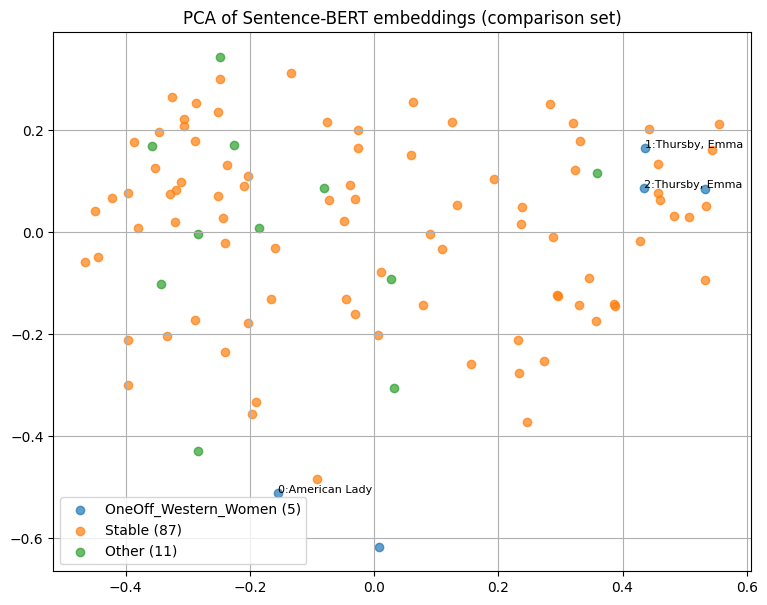


[7] SUMMARY (raw numeric verdicts)
  TF-IDF top-20 contains Thursby? False
  SBERT top-20 contains Thursby? False
  Burrows' Delta top-20 contains Thursby? False

Detailed top 10 results (TF-IDF / SBERT / Burrows):
TF-IDF top10:
 index                 Name              Audience_clean  tfidf_sim
     0         LXXIII Madam               American Lady   1.000000
    46       LXXVIII Sister                  Hale, Mary   0.115217
    52            XC Sister              Farmer, S Miss   0.089477
    17          LXXI Rakhal          Brahmananda, Swami   0.089245
    65        CXLIII Margot            Nivedita, Sister   0.082091
    21       XXXIX Alasinga           Perumal, Alasinga   0.080914
    75               VI Sir               Bose, Balaram   0.079247
    39    LXVI Nanjunda Rao               Rao, Nanjunda   0.076893
    91 LXXVII Sarat Chandra Chakravarty, Sharat Chandra   0.072674
   102          IL Alasinga           Perumal, Alasinga   0.066245

SBERT top10:
 index             

In [26]:
# =============================================================================
# VERIFY THURSBY POSSIBILITY — MULTI-METHOD COMPARISON
# Compares LXXIII Madam vs Emma Thursby letters using TF-IDF, SBERT, and function-word stylometry
# =============================================================================

import pandas as pd
import numpy as np
import re
import random
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from scipy.stats import zscore

random_state = 42
np.random.seed(random_state)
random.seed(random_state)

print("\n" + "="*120)
print("BEGIN THURSBY VERIFICATION · MULTI-METHOD")
print("="*120)

# -----------------------
# SANITY / defensive checks
# -----------------------
assert "body_text" in letters.columns, "letters must contain body_text"
assert "Audience_clean" in letters.columns, "letters must contain Audience_clean"
assert "Name" in letters.columns, "letters must contain Name"

# find target letter
target_mask = letters["Name"].fillna("").astype(str) == "LXXIII Madam"
if target_mask.sum() == 0:
    raise RuntimeError("Target letter 'LXXIII Madam' not found in letters dataframe")
target_row = letters.loc[target_mask].iloc[0]
target_text = str(target_row["body_text"])
print("[0] Target letter found — index:", target_row.name, " | Audience:", target_row["Audience_clean"])

# -----------------------
# locate Emma Thursby letters (flexible)
# -----------------------
print("\n[1] Locating Thursby letters (flexible matching)")

# common variants to try
variants = [
    "Thursby", "Emma Thursby", "Thursby, Emma", "Thursby, Miss Emma"
]

thursby_mask = pd.Series(False, index=letters.index)
for v in variants:
    thursby_mask = thursby_mask | letters["Audience_clean"].fillna("").str.contains(v, case=False, na=False)

thursby_letters = letters[thursby_mask].copy()
print("  Matches found for Thursby variants:", len(thursby_letters))
if len(thursby_letters) > 0:
    print("  Indexes:", list(thursby_letters.index))
else:
    # fallback: search in 'Audience' raw column
    if "Audience" in letters.columns:
        alt_mask = letters["Audience"].fillna("").str.contains("Thursby", case=False, na=False)
        thursby_letters = letters[alt_mask].copy()
        print("  Fallback raw Audience matches:", len(thursby_letters))
    if len(thursby_letters) == 0:
        print("  No Thursby letters found in corpus. Aborting comparative tests.")
        # still proceed to do nearest-neighbor search across corpus vs target below
        # but return early for Thursby-specific tables

# -----------------------
# prepare comparison set
# -----------------------
print("\n[2] Preparing comparison set")

# include: target, all Thursby letters (if any), and a sample of other letters as background
others = letters[~target_mask & ~thursby_mask].sample(min(100, len(letters) - 1 - len(thursby_letters)),
                                                      random_state=random_state)

comparison_df = pd.concat([letters.loc[target_mask], thursby_letters, others]).reset_index(drop=True)
comparison_df = comparison_df[comparison_df["body_text"].astype(str).str.strip() != ""].reset_index(drop=True)

print("  Comparison set size:", len(comparison_df))
print("  Composition by Audience_clean:")
print(comparison_df["Audience_clean"].value_counts().head(20))

# -----------------------
# TEXT PREP
# -----------------------
def clean_text(s):
    return re.sub(r"\s+", " ", str(s)).strip()

comparison_df["text_clean"] = comparison_df["body_text"].apply(clean_text)
target_pos = comparison_df[comparison_df["Name"] == "LXXIII Madam"].index[0]
print("  Target position in comparison_df:", target_pos)

# -----------------------
# METHOD A: TF-IDF cosine similarity
# -----------------------
print("\n[3] TF-IDF similarity (body_text)")

tfv = TfidfVectorizer(min_df=1, stop_words="english")
tfidf_matrix = tfv.fit_transform(comparison_df["text_clean"])

tfidf_sims = cosine_similarity(tfidf_matrix[target_pos], tfidf_matrix).flatten()
tfidf_rank = pd.DataFrame({
    "index": range(len(tfidf_sims)),
    "Name": comparison_df["Name"],
    "Audience_clean": comparison_df["Audience_clean"],
    "tfidf_sim": tfidf_sims
}).sort_values("tfidf_sim", ascending=False).reset_index(drop=True)

print("Top 15 by TF-IDF similarity to target:")
print(tfidf_rank.head(15).to_string(index=False))

# If there are Thursby letters, show where they rank
if len(thursby_letters) > 0:
    thursby_idxs = comparison_df[comparison_df["Audience_clean"].fillna("").str.contains("Thursby", case=False)].index.tolist()
    print("\nTF-IDF sims for Thursby letters (if any):")
    for i in thursby_idxs:
        print(f"  pos {i} | Audience: {comparison_df.loc[i,'Audience_clean']} | tfidf_sim: {tfidf_sims[i]:.4f}")

# -----------------------
# METHOD B: Sentence-BERT embeddings cosine similarity
# -----------------------
print("\n[4] Sentence-BERT embedding similarity (semantic) — computing embeddings")

model = SentenceTransformer("all-MiniLM-L6-v2")
embs = model.encode(comparison_df["text_clean"].tolist(), show_progress_bar=True)

sbert_sims = cosine_similarity(embs[target_pos].reshape(1,-1), embs).flatten()
sbert_rank = pd.DataFrame({
    "index": range(len(sbert_sims)),
    "Name": comparison_df["Name"],
    "Audience_clean": comparison_df["Audience_clean"],
    "sbert_sim": sbert_sims
}).sort_values("sbert_sim", ascending=False).reset_index(drop=True)

print("Top 15 by SBERT similarity to target:")
print(sbert_rank.head(15).to_string(index=False))

if len(thursby_letters) > 0:
    print("\nSBERT sims for Thursby letters (if any):")
    for i in thursby_idxs:
        print(f"  pos {i} | Audience: {comparison_df.loc[i,'Audience_clean']} | sbert_sim: {sbert_sims[i]:.4f}")

# -----------------------
# METHOD C: Function-word stylometry + Burrows' Delta
# -----------------------
print("\n[5] Function-word stylometry (Burrows' Delta)")

# conservative list of function words (standard)
function_words = [
    "the","and","of","to","a","in","that","is","it","for","as","with","was","on","be","by",
    "not","this","which","or","from","but","are","an","at","have","has","had","were","they",
    "their","we","you","he","she","I","me","my","mine","our","ours"
]

# compute normalized frequencies per document
count_vec = CountVectorizer(vocabulary=function_words, lowercase=True, token_pattern=r"[a-zA-Z']+")
fw_counts = count_vec.fit_transform(comparison_df["text_clean"]).toarray().astype(float)
doc_lengths = np.array([len(re.findall(r"[a-zA-Z']+", t.lower())) for t in comparison_df["text_clean"]])
# avoid division by zero
doc_lengths[doc_lengths==0] = 1
fw_freqs = fw_counts / doc_lengths[:, None]

# z-score across corpus for each function word
fw_z = zscore(fw_freqs, axis=0, ddof=0)
fw_z = np.nan_to_num(fw_z)

# Burrows' Delta: mean absolute difference of z-scores
target_z = fw_z[target_pos]
deltas = np.mean(np.abs(fw_z - target_z), axis=1)

delta_rank = pd.DataFrame({
    "index": range(len(deltas)),
    "Name": comparison_df["Name"],
    "Audience_clean": comparison_df["Audience_clean"],
    "burrows_delta": deltas
}).sort_values("burrows_delta", ascending=True).reset_index(drop=True)  # smaller = closer

print("Top 15 by Burrows' Delta (closest first):")
print(delta_rank.head(15).to_string(index=False))

if len(thursby_letters) > 0:
    print("\nBurrows' Delta for Thursby letters (if any):")
    for i in thursby_idxs:
        print(f"  pos {i} | Audience: {comparison_df.loc[i,'Audience_clean']} | delta: {deltas[i]:.4f}")

# -----------------------
# METHOD D: PCA visualization of SBERT embeddings
# -----------------------
print("\n[6] PCA visualization of SBERT embeddings (2D). Plotting...")

pca = PCA(n_components=2, random_state=random_state)
emb_pca = pca.fit_transform(embs)
comparison_df["emb_pca0"] = emb_pca[:,0]
comparison_df["emb_pca1"] = emb_pca[:,1]

plt.figure(figsize=(9,7))
colors = {"oneoff":"green", "frequent":"blue", "target":"red"}
for grp in comparison_df["group"].unique():
    sub = comparison_df[comparison_df["group"]==grp]
    plt.scatter(sub["emb_pca0"], sub["emb_pca1"], label=f"{grp} ({len(sub)})", alpha=0.7)
# label points (small)
for i, r in comparison_df.iterrows():
    if i == target_pos or (len(thursby_letters)>0 and i in thursby_idxs):
        plt.text(r["emb_pca0"], r["emb_pca1"], str(i) + ":" + str(r["Audience_clean"]), fontsize=8)
plt.title("PCA of Sentence-BERT embeddings (comparison set)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# SUMMARY / direct verdict prints
# -----------------------
print("\n[7] SUMMARY (raw numeric verdicts)")

# TF-IDF top-k whether Thursby letters present
tfidf_top_idxs = tfidf_rank.head(20)["index"].tolist()
sbert_top_idxs = sbert_rank.head(20)["index"].tolist()
delta_top_idxs = delta_rank.head(20)["index"].tolist()

print("  TF-IDF top-20 contains Thursby?", any(i in thursby_idxs for i in tfidf_top_idxs) if len(thursby_letters)>0 else "no Thursby letters")
print("  SBERT top-20 contains Thursby?", any(i in thursby_idxs for i in sbert_top_idxs) if len(thursby_letters)>0 else "no Thursby letters")
print("  Burrows' Delta top-20 contains Thursby?", any(i in thursby_idxs for i in delta_top_idxs) if len(thursby_letters)>0 else "no Thursby letters")

print("\nDetailed top 10 results (TF-IDF / SBERT / Burrows):")
print("TF-IDF top10:")
print(tfidf_rank.head(10).to_string(index=False))
print("\nSBERT top10:")
print(sbert_rank.head(10).to_string(index=False))
print("\nBurrows top10:")
print(delta_rank.head(10).to_string(index=False))

print("\nComplete comparison_df indices for cross-reference:")
print(comparison_df[["Name","Audience_clean"]].reset_index().to_string(index=False))

print("\n" + "="*120)
print("END THURSBY VERIFICATION")
print("="*120)
